# Clustering and Classification

- K-means: **Unsupervised** clustering.
  - There are many more classification algorithms.
- Naive Bayes Classifier: **Supervised** classification

## K-means

Some basic **definitions**:
- Unsupervised learning is having UNLABELLED data and finding patterns / insights.
- Clustering algorithms are an example of unsupervised learning > Group of points that are more similar to each other than those in other groups/clusters.


**K-means** is a popular unsupervised learning algorithm used for clustering.`
- It partitions the dataset into $n$ clusters by assigning each data point to the nearest cluster center, then recalculating the centers based on the assigned points.
- This process repeats until convergence, where cluster assignments no longer change.
- The goal is to minimize the within-cluster variance.
- It’s simple and efficient for large datasets but requires the number of clusters to be predefined.

### Algorithm Steps

**Fitting**
1. Randomly create $n$ cluster centres
2. Loop:
   1. Compute the distance of each point to each cluster centre
   2. Assign each point to its closest cluster centre
   3. Update the cluster centres to be the mean of the points assigned to them

**Inference**
1. Compute the distances to each cluster centre.
2. Assign the data point to the closest cluster centre.

**Details**
We can either continue until the cluster centres do not update (this will happen when no point has changed its assigned cluster), or terminate early, as long as no cluster centre moved by more than a tolerance value.

### Algorithm Mathematically:

1. **Initialization:**
   - Choose $k$ initial cluster centers $\mu_1, \mu_2, \ldots, \mu_k$ randomly from the dataset.

2. **Assignment Step:**
   - For each data point $x_i$ in the dataset, assign it to the nearest cluster center:
     $$
     C_i = \arg\min_{j} \| x_i - \mu_j \|^2
     $$
     where $C_i$ is the index of the cluster center closest to $x_i$, and $\| x_i - \mu_j \|^2$ is the squared Euclidean distance between $x_i$ and $\mu_j$.

3. **Update Step:**
   - Update each cluster center to be the mean of the points assigned to it:
     $$
     \mu_j = \frac{1}{|C_j|} \sum_{x_i \in C_j} x_i
     $$
     where $|C_j|$ is the number of points in cluster $j$.

4. **Convergence:**
   - Repeat the Assignment and Update steps until the cluster centers $\mu_1, \mu_2, \ldots, \mu_k$ no longer change significantly, i.e., until the change in the cluster centers is less than a specified tolerance value or the assignments no longer change.

The algorithm aims to minimize the following objective function (within-cluster sum of squares):
$$
\sum_{j=1}^k \sum_{x_i \in C_j} \| x_i - \mu_j \|^2
$$

This process iteratively refines the cluster centers and assignments to minimize the variance within each cluster.

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris
import math
import numpy as np
import random

In [2]:
# @title load the dataset

iris = load_iris()
data = pd.DataFrame(iris.data, columns=iris.feature_names)
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


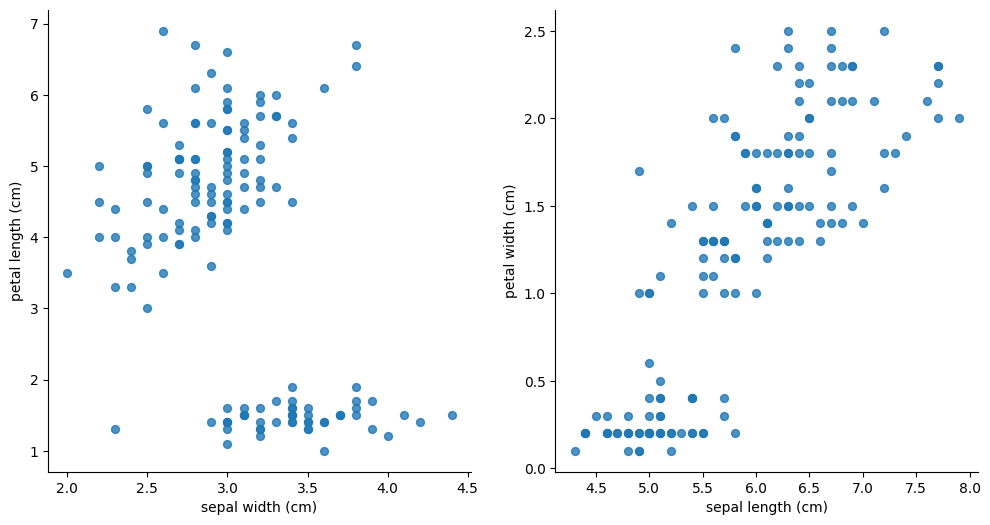

In [3]:
# @title sepal width (cm) vs petal length (cm)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

data.plot(kind='scatter', x='sepal width (cm)', y='petal length (cm)', s=32, alpha=.8, ax=axes[0])
axes[0].spines[['top', 'right',]].set_visible(False)

data.plot(kind='scatter', x='sepal length (cm)', y='petal width (cm)', s=32, alpha=.8, ax=axes[1])
axes[1].spines[['top', 'right',]].set_visible(False)

In [4]:
# @title for demonstration, pick only two features from the data

X = iris.data[:, [1, 2]]  # sepal width and petal length are the features we will use
X[0:5], len(X)

(array([[3.5, 1.4],
        [3. , 1.4],
        [3.2, 1.3],
        [3.1, 1.5],
        [3.6, 1.4]]),
 150)

In [6]:
# @title define a distance metric

def calc_euclidian_distance(d_1, d_2):
    return math.sqrt(((d_1[0] - d_2[0]) ** 2) + ((d_1[1] - d_2[1]) ** 2))

In [7]:
# @title initialise cluster centres
def initialise_clusters(data, num_clusters, log=False):
  # Get max and min values of the features
  x1_min, x1_max = math.floor(data[:, 0].min()), math.ceil(data[:, 0].max())
  x2_min, x2_max =  math.floor(data[:, 1].min()), math.ceil(data[:, 1].max())

  if log:
    print(f"Range of x1: {x1_min} to {x1_max}, x2: {x2_min} to {x2_max}")

  clusters = []

  # Create new centres
  while len(clusters) < num_clusters:
    new_centre = [round(random.uniform(x1_min,  x1_max), 1),
                  round(random.uniform(x2_min,  x2_max), 1)]
    # check unique to avoid duplicates
    if new_centre not in clusters:
      clusters.append(new_centre)

  if log:
    print(f"Initial clusters: {clusters}")

  return clusters

initial_clusters = initialise_clusters(X, 3, True)

Range of x1: 2 to 5, x2: 1 to 7
Initial clusters: [[4.0, 4.6], [3.1, 4.5], [4.3, 3.3]]


In [8]:
# @title K-means algorithm

def k_means(data, num_clusters, seed=1, log=False):
  # Set the seed
  random.seed(seed)

  clusters = initialise_clusters(data, num_clusters, log)

  # Assign each data point to a cluster. We choose cluster to 0.
  assignments = [0] * len(data)

  changed = True

  while changed:
    # Assign each point to the cluster with the nearest centre.
    for i, d in enumerate(data):
      # For each data point, compute the distance to each cluster center
      distances = [calc_euclidian_distance(d, c) for c in clusters]

      # Then assign the point to the cluster with the nearest center.
      assignments[i] = np.array(distances).argmin()

    # Recompute cluster centres.
    cluster_x_coord = [0] * len(clusters)
    cluster_y_coord = [0] * len(clusters)
    counts = [0] * len(clusters)

    # Sum up x and y coordinate values of points in each cluster.
    for d, a in zip(X, assignments):
      cluster_x_coord[a] += d[0]
      cluster_y_coord[a] += d[1]
      counts[a] += 1

    if log:
      print(f"Count of points per cluster: {counts}")

    # Compute new cluster centres
    new_centres = []
    for i, count in enumerate(counts):
      if count == 0:
        new_centres.append(initialise_clusters(data, num_clusters)[0])
      else:
        new_centres.append(
          [(cluster_x_coord[i]/count),
          (cluster_y_coord[i]/count)])

    changed = (new_centres != clusters)

    if log:
      print(f"Update clusters from {clusters} to {new_centres}")
    clusters = new_centres

  return clusters, assignments

clusters, assignments = k_means(X, 2, log=True)

Range of x1: 2 to 5, x2: 1 to 7
Initial clusters: [[2.4, 6.1], [4.3, 2.5]]
Count of points per cluster: [89, 61]
Update clusters from [[2.4, 6.1], [4.3, 2.5]] to [[2.908988764044944, 5.065168539325843], [3.2737704918032793, 1.8508196721311476]]
Count of points per cluster: [97, 53]
Update clusters from [[2.908988764044944, 5.065168539325843], [3.2737704918032793, 1.8508196721311476]] to [[2.8865979381443303, 4.958762886597939], [3.369811320754718, 1.560377358490566]]
Count of points per cluster: [99, 51]
Update clusters from [[2.8865979381443303, 4.958762886597939], [3.369811320754718, 1.560377358490566]] to [[2.8757575757575764, 4.925252525252526], [3.409803921568628, 1.4921568627450983]]
Count of points per cluster: [99, 51]
Update clusters from [[2.8757575757575764, 4.925252525252526], [3.409803921568628, 1.4921568627450983]] to [[2.8757575757575764, 4.925252525252526], [3.409803921568628, 1.4921568627450983]]


In [11]:
from sklearn import metrics
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

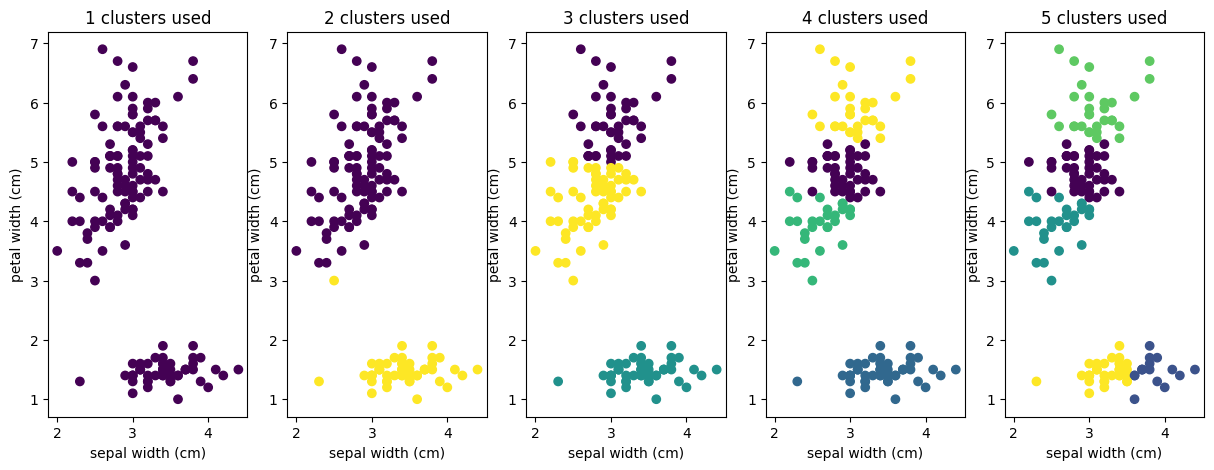

In [12]:
# @title Explore a range of num_clusters

MAX_N = 6
plt.figure(figsize=(3*MAX_N, 5))
plt.style.use('default')

for n in range(1, MAX_N):
  plt.subplot(1, MAX_N, n)
  _, assignments = k_means(X, n)
  plt.scatter(X[:, 0], X[:, 1], c=assignments)
  plt.xlabel(iris.feature_names[1], fontsize=10)
  plt.ylabel(iris.feature_names[3], fontsize=10)
  plt.title(f'{n} clusters used')

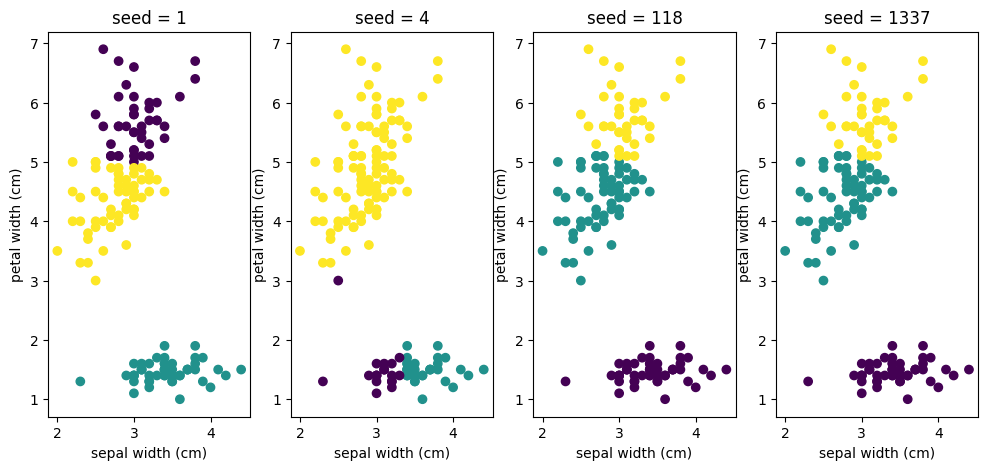

In [13]:
# @title The initial clusters can be important!

seeds = [1, 4, 118, 1337]
plt.figure(figsize=(3*len(seeds), 5))

for i, seed in enumerate(seeds):
  plt.subplot(1, len(seeds), i+1)
  _, assignments = k_means(X, 3, seed, False)
  plt.scatter(X[:, 0], X[:, 1], c=assignments)
  plt.xlabel(iris.feature_names[1], fontsize=10)
  plt.ylabel(iris.feature_names[3], fontsize=10)
  plt.title(f'seed = {seed}')

Text(0.5, 1.0, 'k-Means Implementation')

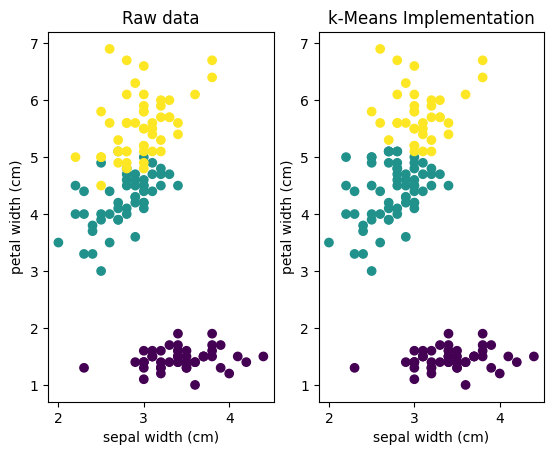

In [14]:
# @title Compare to truth

# Plot the raw data
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=iris.target.astype(float))
plt.xlabel(iris.feature_names[1], fontsize=10)
plt.ylabel(iris.feature_names[3], fontsize=10)
plt.title('Raw data')

# Plot the clusters we found
plt.subplot(1, 2, 2)
_, assignments = k_means(X, 3, 5, False)
plt.scatter(X[:, 0], X[:, 1], c=assignments)
plt.xlabel( iris.feature_names[1], fontsize=10)
plt.ylabel( iris.feature_names[3], fontsize=10)
plt.title('k-Means Implementation')

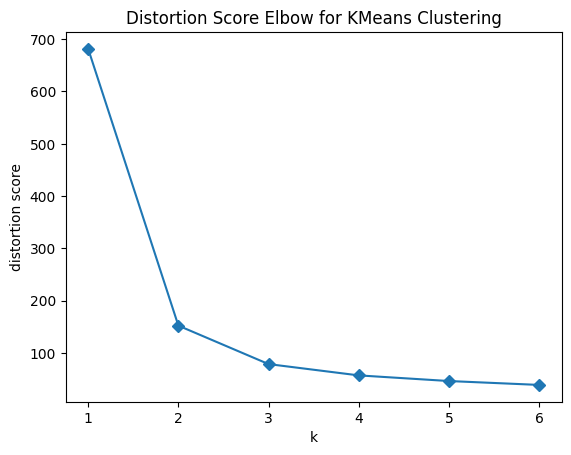

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
# @title Find the optimal number of clusters

model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model,
                              k=(1,7),
                              metric='distortion',
                              locate_elbow=False,
                              timings=False)

visualizer.fit(iris.data)
visualizer.show()

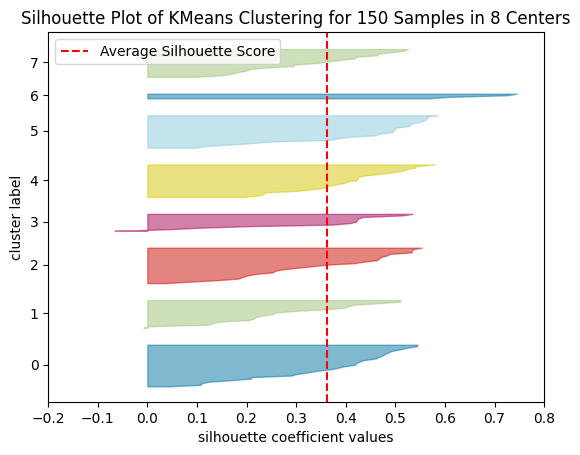

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 150 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [17]:
from yellowbrick.cluster import SilhouetteVisualizer

# Instantiate the clustering model
model = KMeans(n_init=10)

# Create the visualizer
visualizer = SilhouetteVisualizer(model,
                                  k=(1,7),
                                  colors='yellowbrick')

# Fit the data to the visualizer
visualizer.fit(iris.data)

# Finalize and render the figure
visualizer.show()

In [16]:
# @title Assess performance
"""
  Rand index. For all possible pairs of data points, we count the number that agree, that is both our classification and the ground truth either:
  - Assign both points to the same cluster , or
  - assign the points to different clusters

  RI = (number of agreeing pairs) / (number of pairs)
"""

model = KMeans(n_clusters=3, n_init=10)
model.fit(iris.data)
model_labels = model.labels_
rand_score = metrics.adjusted_rand_score(iris.target, model_labels)
print(f"Rand index for k-Means from scikit-learn: {rand_score:.4}")

Rand index for k-Means from scikit-learn: 0.7302


## Other clustering algorithms:

1. **K-means Clustering**
- **Description**: Partitions the data into $k$ clusters by minimizing the within-cluster variance.
- **Strengths**: Simple, efficient, and works well for large datasets.
- **Weaknesses**: Requires the number of clusters to be predefined, sensitive to initial cluster centers and outliers.

2. **Hierarchical Clustering**
- **Description**: Builds a hierarchy of clusters either in a bottom-up approach (agglomerative) or top-down approach (divisive).
- **Strengths**: Does not require a predefined number of clusters, produces a dendrogram for visualizing the clustering process.
- **Weaknesses**: Computationally intensive for large datasets, less scalable.

3. **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**
- **Description**: Groups points that are closely packed together, marking points in low-density regions as outliers.
- **Strengths**: Can find arbitrarily shaped clusters, robust to outliers, does not require the number of clusters to be predefined.
- **Weaknesses**: Requires appropriate parameter selection (epsilon and minimum points), not well-suited for clusters with varying densities.

4. **Gaussian Mixture Models (GMM)**
- **Description**: Assumes data is generated from a mixture of several Gaussian distributions, using the Expectation-Maximization algorithm to find the best fit.
- **Strengths**: Can model clusters with different shapes and sizes, probabilistic framework.
- **Weaknesses**: Requires the number of components to be predefined, can be sensitive to initial parameters.

5. **Mean Shift Clustering**
- **Description**: A non-parametric method that shifts each data point to the average of data points in its neighborhood iteratively.
- **Strengths**: Does not require a predefined number of clusters, can find clusters of arbitrary shapes.
- **Weaknesses**: Computationally intensive, choice of bandwidth parameter can be tricky.

6. **Agglomerative Clustering**
- **Description**: A type of hierarchical clustering that merges the closest pairs of clusters iteratively until all points are in a single cluster.
- **Strengths**: No need to specify the number of clusters, produces a hierarchy of clusters.
- **Weaknesses**: Computationally expensive for large datasets, sensitive to noise and outliers.

7. **Affinity Propagation**
- **Description**: Based on message passing between data points, it finds exemplars that best represent clusters.
- **Strengths**: Does not require the number of clusters to be predefined, can identify exemplar points.
- **Weaknesses**: Computationally expensive, requires careful tuning of parameters.

8. **Spectral Clustering**
- **Description**: Uses the eigenvalues of a similarity matrix to perform dimensionality reduction before clustering in fewer dimensions.
- **Strengths**: Can capture complex cluster structures, useful for graph-based data.
- **Weaknesses**: Requires the number of clusters to be predefined, computationally intensive for large datasets.

Each of these algorithms has its own use cases and is chosen based on the specific characteristics of the data and the problem at hand. For instance, K-means is popular for its simplicity and speed, while DBSCAN is preferred for datasets with noise and varying densities.

### Gaussian Mixture Models (GMM)

#### GMM covariances

We compare GMMs with spherical, diagonal, full, and tied covariance matrices in increasing order of performance. Although one would expect full covariance to perform best in general, it is prone to overfitting on small datasets and does not generalize well to held out test data.

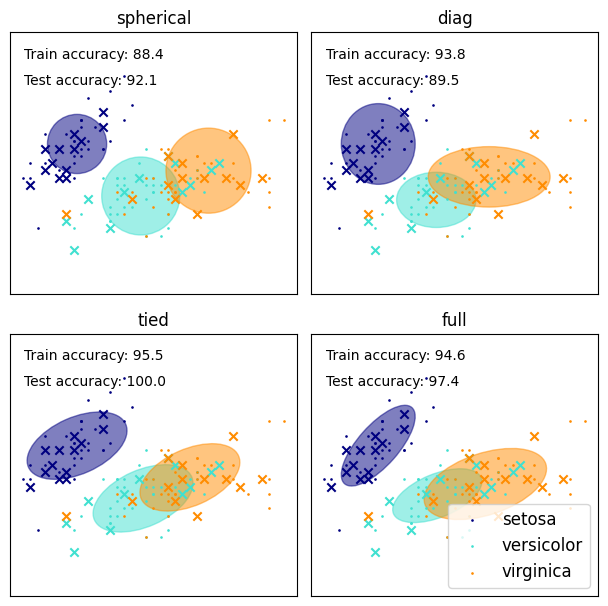

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

colors = ["navy", "turquoise", "darkorange"]


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], angle=180 + angle, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")


iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {
    cov_type: GaussianMixture(
        n_components=n_classes, covariance_type=cov_type, max_iter=20, random_state=0
    )
    for cov_type in ["spherical", "diag", "tied", "full"]
}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(
    bottom=0.01, top=0.95, hspace=0.15, wspace=0.05, left=0.01, right=0.99
)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array(
        [X_train[y_train == i].mean(axis=0) for i in range(n_classes)]
    )

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(
            data[:, 0], data[:, 1], s=0.8, color=color, label=iris.target_names[n]
        )
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker="x", color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, "Train accuracy: %.1f" % train_accuracy, transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, "Test accuracy: %.1f" % test_accuracy, transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc="lower right", prop=dict(size=12))


plt.show()

#### Density Estimation for a Gaussian mixture

Plot the density estimation of a mixture of two Gaussians. Data is generated from two Gaussians with different centers and covariance matrices.

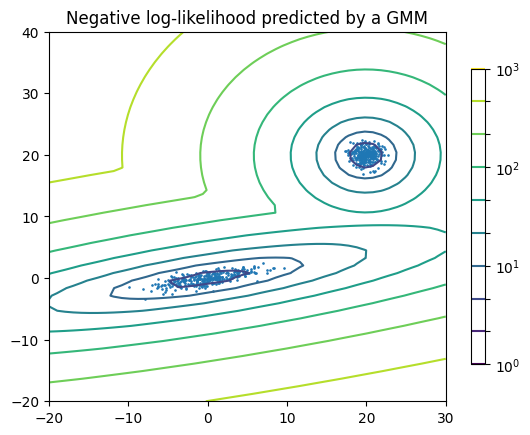

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

from sklearn import mixture

n_samples = 300

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

# generate zero centered stretched Gaussian data
C = np.array([[0.0, -0.7], [3.5, 0.7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=2, covariance_type="full")
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-20.0, 30.0)
y = np.linspace(-20.0, 40.0)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(
    X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10)
)
CB = plt.colorbar(CS, shrink=0.8, extend="both")
plt.scatter(X_train[:, 0], X_train[:, 1], 0.8)

plt.title("Negative log-likelihood predicted by a GMM")
plt.axis("tight")
plt.show()

## Naive Bayes Classifier

Bayes Theorem helps you update your beliefs about something when you get new information. It's like if you thought it might rain today (that's your initial guess), but then you see dark clouds in the sky. With Bayes Theorem, you can combine your initial guess with the new clue (the dark clouds) to make a better prediction about whether it will actually rain.

**Used with categorical data for supervised learning** 
- Conditional probability: ($P(\text{x=sun} \mid \text{y=yes})$) [Probability of X ocurring given y]
- Naive because it assumes that the features are conditionally independent. Therefore, it assumes:
$$
P(\text{x,v,z} \mid \text{y}) = P(\text{x} \mid \text{y}) P(\text{v} \mid \text{y}) P(\text{z} \mid \text{y})
$$

### Bayes Theorem

$$P(\text{Hypothesis} \mid \text{Data}) = \frac{P(\text{Data} \mid \text{Hypothesis}) \times P(\text{Hypothesis})}{P(\text{Data})}$$

1. Prior Probability ($P(\text{Hypothesis})$)
- **Definition**: The prior probability represents the initial belief about the probability of a hypothesis before any new data is observed.
- **Example**: If you want to classify emails as spam or not spam, the prior probability would be the proportion of spam emails in your training dataset before considering the specific features of an email.

2. Likelihood ($P(\text{Data} \mid \text{Hypothesis})$) 
- **Definition**: The likelihood is the probability of observing the data given that the hypothesis is true. It measures how well the hypothesis explains the data.
- **Example**: For the spam email classifier, the likelihood is the probability of observing certain words or features in an email given that the email is spam.

3. Posterior Probability ($P(\text{Hypothesis} \mid \text{Data})$)
- **Definition**: The posterior probability is the updated probability of the hypothesis after taking the new data into account. It combines the prior probability and the likelihood.
- **Example**: In the email classifier, the posterior probability is the probability that an email is spam given the specific words or features it contains.

4. Marginal Likelihood ($P(\text{Data})$)
- **Definition**: The marginal likelihood, also known as the evidence, is the probability of observing the data under all possible hypotheses. It normalizes the posterior probability.
- **Example**: In the email classifier, the marginal likelihood is the total probability of observing the specific words or features in any email, whether it is spam or not.

Summary in Context of Naive Bayes Classifier
- **Prior Probability**: Initial knowledge about the frequency of classes (e.g., spam vs. not spam).
- **Likelihood**: How likely the observed data (features) is under each class (e.g., word frequency in spam emails).
- **Posterior Probability**: Updated belief about the class after observing the data (e.g., probability that an email is spam given its words).
- **Marginal Likelihood**: Normalizing factor ensuring probabilities sum to 1 across all classes (e.g., total probability of the observed words in any email).

#### Example Mathematically

1. **Prior Probability ($P(\text{Spam})$ and $P(\text{NotSpam})$)**
- Mathematical Definition: 
  $$
  P(\text{Spam}) = \frac{\text{Number of spam emails}}{\text{Total number of emails}}
  $$
  $$
  P(\text{NotSpam}) = \frac{\text{Number of non-spam emails}}{\text{Total number of emails}}
  $$
- These represent the probabilities of an email being spam or not spam before looking at the email's content.

2. **Likelihood ($P(\text{Words} \mid \text{Spam})$ and $P(\text{Words} \mid \text{NotSpam})$)**
- Mathematical Definition: Assuming words $w_1, w_2, \ldots, w_n$ appear in the email, and using the Naive Bayes assumption of feature independence:
  $$
  P(\text{Words} \mid \text{Spam}) = P(w_1, w_2, \ldots, w_n \mid \text{Spam}) = P(w_1 \mid \text{Spam}) \cdot P(w_2 \mid \text{Spam}) \cdot \ldots \cdot P(w_n \mid \text{Spam})
  $$
  $$
  P(\text{Words} \mid \text{NotSpam}) = P(w_1, w_2, \ldots, w_n \mid \text{NotSpam}) = P(w_1 \mid \text{NotSpam}) \cdot P(w_2 \mid \text{NotSpam}) \cdot \ldots \cdot P(w_n \mid \text{NotSpam})
  $$
- These represent the probability of observing the specific words in the email given that the email is spam or not spam.

3. **Posterior Probability ($P(\text{Spam} \mid \text{Words})$ and $P(\text{NotSpam} \mid \text{Words})$)**
- Mathematical Definition: Using Bayes Theorem:
  $$
  P(\text{Spam} \mid \text{Words}) = \frac{P(\text{Words} \mid \text{Spam}) \cdot P(\text{Spam})}{P(\text{Words})}
  $$
  $$
  P(\text{NotSpam} \mid \text{Words}) = \frac{P(\text{Words} \mid \text{NotSpam}) \cdot P(\text{NotSpam})}{P(\text{Words})}
  $$
- These represent the updated probabilities that the email is spam or not spam after considering the specific words in the email.

4. **Marginal Likelihood ($P(\text{Words})$)**
- Mathematical Definition: This is the normalization factor ensuring that the sum of the posterior probabilities for all classes equals 1:
  $$
  P(\text{Words}) = P(\text{Words} \mid \text{Spam}) \cdot P(\text{Spam}) + P(\text{Words} \mid \text{NotSpam}) \cdot P(\text{NotSpam})
  $$
- This represents the total probability of observing the specific words in the email under all possible hypotheses (spam and not spam).


5. **Putting It All Together**

For an email with words $w_1, w_2, \ldots, w_n$, the probability that it is spam is computed as:

$$
P(\text{Spam} \mid \text{Words}) = \frac{P(w_1 \mid \text{Spam}) \cdot P(w_2 \mid \text{Spam}) \cdot \ldots \cdot P(w_n \mid \text{Spam}) \cdot P(\text{Spam})}{P(w_1 \mid \text{Spam}) \cdot P(\text{Spam}) + P(w_1 \mid \text{NotSpam}) \cdot P(\text{NotSpam})}
$$

Similarly, for the probability that it is not spam:

$$
P(\text{NotSpam} \mid \text{Words}) = \frac{P(w_1 \mid \text{NotSpam}) \cdot P(w_2 \mid \text{NotSpam}) \cdot \ldots \cdot P(w_n \mid \text{NotSpam}) \cdot P(\text{NotSpam})}{P(w_1 \mid \text{Spam}) \cdot P(\text{Spam}) + P(w_1 \mid \text{NotSpam}) \cdot P(\text{NotSpam})}
$$

These probabilities are used to classify the email as spam or not spam based on which posterior probability is higher.

#### Example Straightforward

| Weather | Temperature | Wind  | Tennis |
|---------|-------------|-------|--------|
| Sun     | Hot         | Strong| Yes    |
| Rain    | Hot         | Mild  | No     |
| Cloudy  | Cold        | Mild  | Yes    |
| Sun     | Cold        | Mild  | Yes    |

- **Prior**: 
  $$
  P(\text{tennis} = \text{yes}) = \frac{3}{4}
  $$
- **Conditional Probability**:
  $$
  P(\text{weather} = \text{sun} \mid \text{tennis} = \text{yes}) = \frac{2}{3}
  $$

**Table**: Do I play tennis?

| Weather | Temperature | Wind   | Tennis |
|---------|-------------|--------|--------|
| Sun     | Hot         | Strong | Yes    |
| Rain    | Hot         | Mild   | No     |
| Cloudy  | Cold        | Mild   | Yes    |
| Sun     | Cold        | Mild   | Yes    |
| Rain    | Cold        | Strong | ???    |

$$P(\text{tennis} = \text{yes} \mid \text{data}) \propto P(\text{yes}) P(\text{sun} \mid \text{yes}) P(\text{cold} \mid \text{yes}) P(\text{mild} \mid \text{yes})$$

$$
P(\text{tennis} = \text{yes} \mid \text{data}) = \frac{3}{4} \times \frac{2}{3} \times \frac{2}{3} \times \frac{2}{3} = \frac{2}{9}
$$

$$P(\text{tennis} = \text{no} \mid \text{data}) \propto P(\text{no}) P(\text{sun} \mid \text{no}) P(\text{cold} \mid \text{no}) P(\text{mild} \mid \text{no})$$

$$
P(\text{tennis} = \text{no} \mid \text{data}) = \frac{1}{4} \times \frac{0}{1} \times \frac{0}{1} \times \frac{1}{1} = 0
$$

Therefore,

$$
P(\text{yes} \mid \text{data}) = \frac{P(\text{yes} \mid \text{data})}{P(\text{yes} \mid \text{data}) + P(\text{no} \mid \text{data})} = \frac{\frac{2}{9}}{\frac{2}{9} + 0} = 1
$$

### Conditional Independence

The features are not independent: the weather is causally related to the temperature.

Are the features conditionally independent? Suppose I never play tennis when it is both raining and windy. Then $P(\text{rain} \mid \text{yes})$ and $P(\text{strong} \mid \text{yes})$ are not independent: if one is true, then the other must be false.

#### What might conditional independence look like?

| Weight | Likes baths | Animal |
|--------|-------------|--------|
| Light  | No          | Cat    |
| Heavy  | Yes         | Dog    |
| Heavy  | No          | Cat    |

Cats typically hate baths. But fat (heavy) cats are just as likely to hate baths as normal cats. Therefore, conditional on the animal, knowing the weight does not influence whether they enjoy bathing.

### Algorithm

#### Steps

**Fitting**
1. Compute the prior
2. Compute the feature likelihoods

**Inference**
1. For each class, multiply the prior probability by the likelihood, which is the product of the conditional feature probabilities.
2. Select the class with the highest probability.

#### Details
**We use log probabilities to avoid floating point precision errors**
- We can always transform it back if needed. Although usually we just want the class with the higher probability - not the number per se.


In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split

from ucimlrepo import fetch_ucirepo

In [46]:
# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# variable information
heart_disease.variables

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,None,years,no
1,sex,Feature,Categorical,Sex,None,None,no
2,cp,Feature,Categorical,None,None,None,no
3,trestbps,Feature,Integer,None,resting blood pressure (on admission to the ho...,mm Hg,no
4,chol,Feature,Integer,None,serum cholestoral,mg/dl,no
5,fbs,Feature,Categorical,None,fasting blood sugar > 120 mg/dl,None,no
6,restecg,Feature,Categorical,None,None,None,no
7,thalach,Feature,Integer,None,maximum heart rate achieved,None,no
8,exang,Feature,Categorical,None,exercise induced angina,None,no
9,oldpeak,Feature,Integer,None,ST depression induced by exercise relative to ...,None,no


In [48]:
# @title Use only categorical features for demonstration

category_features = heart_disease.variables[(heart_disease.variables.type == "Categorical") & (heart_disease.variables.missing_values == "no")].name

# data (as pandas dataframes)
X = heart_disease.data.features[category_features]
y = pd.Series(heart_disease.data.targets.num, name='class')

feature_counts = dict((c, X[c].value_counts()) for c in X.columns)
feature_counts['target'] = y.value_counts()
pd.DataFrame(feature_counts)

,sex,cp,fbs,restecg,exang,slope,target
0,97.0,NaN,258.0,151.0,204.0,NaN,164
1,206.0,23.0,45.0,4.0,99.0,142.0,55
2,NaN,50.0,NaN,148.0,NaN,140.0,36
3,NaN,86.0,NaN,NaN,NaN,21.0,35
4,NaN,144.0,NaN,NaN,NaN,NaN,13


In [49]:
# @title Partition the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

print((len(X_train), len(X_test)))
y.value_counts(),  y_test.value_counts()

(242, 61)


(class
 0    164
 1     55
 2     36
 3     35
 4     13
 Name: count, dtype: int64,
 class
 0    33
 1    11
 3     7
 2     7
 4     3
 Name: count, dtype: int64)

In [52]:
import numpy as np
from typing import Dict, Optional

In [53]:
def compute_prior(target: pd.Series, log: bool = False) -> pd.Series:
  class_counts = target.value_counts().sort_index()

  # Calculate prior probabilities, p(y)
  prior = class_counts / target.sum()

  if log:
    print("Class counts:", class_counts, "Prior:", prior, sep='\n')

  return prior

prior = compute_prior(y, True)

Class counts:
class
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64
Prior:
class
0    0.577465
1    0.193662
2    0.126761
3    0.123239
4    0.045775
Name: count, dtype: float64


In [54]:
pd.crosstab(X['cp'], y)

class,0,1,2,3,4
cp,,,,,
1,16,5,1,0,1
2,41,6,1,2,0
3,68,9,4,4,1
4,39,35,30,29,11


In [55]:
def compute_likelihoods(data: pd.DataFrame, target: pd.Series, smoothing: int=1,
                        log: bool=False) -> Dict[str, pd.DataFrame]:
  """Calculate likelihoods, p(x|y)
  For each target class, we find the proportion of the times the feature
  took a particular value."""

  likelihoods = {}
  for feature in data.columns:
    cross_table = pd.crosstab(data[feature], target) + smoothing
    likelihoods[feature] = cross_table / cross_table.sum()

  if log:
    for feature in data.columns:
      print(f'Likelihood for feature {feature}:', likelihoods[feature], sep='\n')

  return likelihoods

likelihoods = compute_likelihoods(X, y, 1, True)

Likelihood for feature sex:
class         0         1         2         3    4
sex                                               
0      0.439759  0.175439  0.210526  0.216216  0.2
1      0.560241  0.824561  0.789474  0.783784  0.8
Likelihood for feature cp:
class         0         1      2         3         4
cp                                                  
1      0.101190  0.101695  0.050  0.025641  0.117647
2      0.250000  0.118644  0.050  0.076923  0.058824
3      0.410714  0.169492  0.125  0.128205  0.117647
4      0.238095  0.610169  0.775  0.769231  0.705882
Likelihood for feature fbs:
class         0         1         2         3         4
fbs                                                    
0      0.855422  0.912281  0.736842  0.756757  0.866667
1      0.144578  0.087719  0.263158  0.243243  0.133333
Likelihood for feature restecg:
class           0         1         2         3       4
restecg                                                
0        0.574850  0.413793

In [56]:
# @title likelihoods without smoothing

compute_likelihoods(X, y, 0)['cp']

class,0,1,2,3,4
cp,,,,,
1,0.097561,0.090909,0.027778,0.000000,0.076923
2,0.250000,0.109091,0.027778,0.057143,0.000000
3,0.414634,0.163636,0.111111,0.114286,0.076923
4,0.237805,0.636364,0.833333,0.828571,0.846154


In [57]:
# @title likelihoods with strong smoothing

compute_likelihoods(X, y, 20)['cp']

class,0,1,2,3,4
cp,,,,,
1,0.147541,0.185185,0.181034,0.173913,0.225806
2,0.250000,0.192593,0.181034,0.191304,0.215054
3,0.360656,0.214815,0.206897,0.208696,0.225806
4,0.241803,0.407407,0.431034,0.426087,0.333333


In [58]:
def compute_log_posterior(data: pd.DataFrame, priors: pd.Series,
                          likelihoods: Dict[str, pd.Series], log: bool=False):
  """Compute the log-probability of the samples for each class."""

  # Start with the log prior probabilities
  log_posteriors = np.log(pd.DataFrame([priors for _ in range(len(data))],
                                      index=data.index, columns=priors.index))

  classes = priors.index
  features = data.columns

  # For each new data point
  for idx, d in data.iterrows():
    summed_log_likelihoods = []
    # For each possible class
    for c in classes:
      probs = 0
      # For each feature
      for f in features:
        # get the feature value for this data point
        feature_value = d[f]

        # Add the log likelihood probabilities for this feature
        probs += np.log(likelihoods[f][c].loc[feature_value])

      # The posterior for this class
      summed_log_likelihoods.append(probs)

    # add to the prior values
    log_posteriors.loc[idx] += np.array(summed_log_likelihoods)

  if log:
    print(log_posteriors)

  return log_posteriors

log_posteriors = compute_log_posterior(X_train.iloc[0:3], prior, likelihoods, True)

class         0         1         2         3         4
247   -6.743533 -4.363968 -4.562283 -4.231992 -5.310103
78    -4.916970 -5.825686 -7.730567 -7.147682 -7.661478
177   -6.743533 -4.363968 -4.562283 -4.231992 -5.310103


In [59]:
class NaiveBayesClassifier:
  def __init__(self, smoothing: int=1):
    self.likelihood: Dict[str, pd.Series] = {}
    self.prior: Optional[pd.Series] = None
    self.smoothing: int = smoothing

  def fit(self, data: pd.DataFrame, target: pd.Series):
    """Fits the model by computing the prior and likelihood probabilities"""
    self.features = data.columns
    self.classes = target.value_counts()
    self.classes.sort_index()

    self.prior = compute_prior(target)
    self.likelihood = compute_likelihoods(data, target, self.smoothing)

  def predict(self, data, legal=None):
    """Classify the new data"""
    assert self.prior is not None, 'Must fit the classifier first'

    log_posteriors = compute_log_posterior(data, self.prior, self.likelihood)

    predictions = log_posteriors.idxmax(axis='columns')

    return predictions

In [63]:
from imblearn.over_sampling import RandomOverSampler
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.naive_bayes import CategoricalNB

In [64]:
# @title compare performance to sklearn implementation

table = PrettyTable()
table.add_column("Metric", ["Accuracy", "Confusion Matrix"])

for nbc in [NaiveBayesClassifier(), CategoricalNB()]:
  nbc.fit(X_train, y_train)
  y_pred = nbc.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)  # True values are y-axis, predicted is x-axis

  table.add_column(nbc.__class__.__name__, [f"{accuracy:.2%}", f"{conf_matrix}"])

print(table)

+------------------+----------------------+--------------------+
|      Metric      | NaiveBayesClassifier |   CategoricalNB    |
+------------------+----------------------+--------------------+
|     Accuracy     |        59.02%        |       59.02%       |
| Confusion Matrix |  [[31  1  1  0  0]   | [[31  1  1  0  0]  |
|                  |   [ 7  1  2  1  0]   |  [ 7  1  2  1  0]  |
|                  |   [ 2  2  2  1  0]   |  [ 2  2  2  1  0]  |
|                  |   [ 2  1  2  2  0]   |  [ 2  1  2  2  0]  |
|                  |   [ 2  1  0  0  0]]  |  [ 2  1  0  0  0]] |
+------------------+----------------------+--------------------+


In [65]:
# @title uniform prior

table = PrettyTable()
table.add_column("Metric", ["Accuracy", "Confusion Matrix"])

for fp in [True, False]:
  nbc = CategoricalNB(fit_prior=fp)
  nbc.fit(X_train, y_train)
  y_pred = nbc.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)  # True values are y-axis, predicted is x-axis

  table.add_column(f"fit_prior={fp}", [f"{accuracy:.2%}", f"{conf_matrix}"])

print(table)

+------------------+--------------------+--------------------+
|      Metric      |   fit_prior=True   |  fit_prior=False   |
+------------------+--------------------+--------------------+
|     Accuracy     |       59.02%       |       55.74%       |
| Confusion Matrix | [[31  1  1  0  0]  | [[27  0  1  2  3]  |
|                  |  [ 7  1  2  1  0]  |  [ 5  3  2  1  0]  |
|                  |  [ 2  2  2  1  0]  |  [ 1  2  3  1  0]  |
|                  |  [ 2  1  2  2  0]  |  [ 2  1  2  1  1]  |
|                  |  [ 2  1  0  0  0]] |  [ 0  2  0  1  0]] |
+------------------+--------------------+--------------------+


In [66]:
# @title oversample the minority classes
sampling_strategy = dict((id, max(count, 65)) for id, count in y_train.value_counts().items())

ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=0)

X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

y_train.value_counts(), y_train_resampled.value_counts()

(class
 0    131
 1     44
 2     29
 3     28
 4     10
 Name: count, dtype: int64,
 class
 0    131
 1     65
 2     65
 3     65
 4     65
 Name: count, dtype: int64)

In [67]:
table = PrettyTable()
table.add_column("Metric", ["Accuracy", "Confusion Matrix"])

for resample in [False, True]:
  nbc = CategoricalNB()
  nbc.fit(X_train_resampled, y_train_resampled) if resample else nbc.fit(X_train, y_train)
  y_pred = nbc.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)  # True values are y-axis, predicted is x-axis

  table.add_column(f"resample={resample}", [f"{accuracy:.2%}", f"{conf_matrix}"])

print(table)

+------------------+--------------------+--------------------+
|      Metric      |   resample=False   |   resample=True    |
+------------------+--------------------+--------------------+
|     Accuracy     |       59.02%       |       50.82%       |
| Confusion Matrix | [[31  1  1  0  0]  | [[29  1  1  0  2]  |
|                  |  [ 7  1  2  1  0]  |  [ 7  0  2  1  1]  |
|                  |  [ 2  2  2  1  0]  |  [ 1  1  2  2  1]  |
|                  |  [ 2  1  2  2  0]  |  [ 2  1  1  0  3]  |
|                  |  [ 2  1  0  0  0]] |  [ 2  1  0  0  0]] |
+------------------+--------------------+--------------------+
